## 实验流程概览
1. 环境准备：导入依赖、固定随机种子、配置超参数。
2. 数据加载：使用 torchvision 自动下载/读取 CIFAR-10，并针对训练集加入常用数据增强。
3. 自定义模型：构建含残差模块的 CNN，训练并记录指标。
4. 经典模型：微调 ResNet18 与 VGG11-BN，比较性能与收敛特性。
5. 额外实验：探究数据增强/正则化对结果的影响。
6. 结果整理：绘制 Loss/Accuracy 曲线、输出指标表，撰写分析。

## 1. 环境准备

In [2]:
# 基础依赖与通用配置
import os
import json
import math
import random
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple
 
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
 
plt.style.use("seaborn-v0_8")
 
ROOT = Path.cwd()  # 当前 notebook 所在目录
DATA_ROOT = ROOT / "data"
RESULTS_ROOT = ROOT / "results"
for folder in (DATA_ROOT, RESULTS_ROOT):
    folder.mkdir(parents=True, exist_ok=True)
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
 
CFG = {
    "seed": 42,
    "batch_size": 128,
    "num_workers": 4,
    "epochs_custom": 25,
    "epochs_resnet": 20,
    "epochs_vgg": 18,
    "base_lr": 1e-3,
    "finetune_lr": 5e-4,
    "weight_decay": 5e-4,
    "label_smoothing": 0.05,
    "mixup_alpha": 0.0,  # 可自行开启 mixup
}
 
set_seed(CFG["seed"])
print(f"Running on {device}. Results will be saved to {RESULTS_ROOT.relative_to(ROOT)}")

Running on cpu. Results will be saved to results


## 2. 数据加载与增强

In [3]:
# 数据增强与 DataLoader（带回退与重试）
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
 
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
 
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
 
def _cifar_ready(root: Path) -> bool:
    return (root / "cifar-10-batches-py" / "batches.meta").exists()
 
def _cleanup_partial(root: Path) -> None:
    # 删除可能损坏的压缩包与已解压目录，强制重下
    tar = root / "cifar-10-python.tar.gz"
    extracted = root / "cifar-10-batches-py"
    try:
        if tar.exists():
            tar.unlink()
    except Exception:
        pass
    try:
        if extracted.exists():
            import shutil
            shutil.rmtree(extracted, ignore_errors=True)
    except Exception:
        pass
 
def resolve_cifar_root() -> Path:
    # 优先复用同仓库内已有数据集，避免重复下载
    candidates = [
        DATA_ROOT,
        ROOT.parent.parent / "KNN & CIFAR-10" / "notebooks" / "data",
        ROOT.parent.parent / "MLP-Regularization" / "notebooks" / "data",
    ]
    for c in candidates:
        if _cifar_ready(c):
            print(f"使用已有 CIFAR-10 数据：{c}")
            return c
    # 若没有现成数据，则尝试带重试的下载
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    for attempt in range(3):
        try:
            _cleanup_partial(DATA_ROOT)
            _ = datasets.CIFAR10(root=DATA_ROOT, train=True, download=True)
            if _cifar_ready(DATA_ROOT):
                print(f"CIFAR-10 下载完成：{DATA_ROOT}")
                return DATA_ROOT
        except Exception as e:
            print(f"下载失败（第{attempt+1}次）：{e}")
    raise RuntimeError("CIFAR-10 下载失败，请检查网络，或手动将 cifar-10-batches-py 放到 notebooks/data 下。")
 
cifar_root = resolve_cifar_root()
 
# 划分训练/验证
full_train = datasets.CIFAR10(root=cifar_root, train=True, download=False)
indices = np.arange(len(full_train))
rng = np.random.default_rng(CFG["seed"])
rng.shuffle(indices)
val_size = 5000
train_indices = indices[val_size:]
val_indices = indices[:val_size]
 
train_dataset = datasets.CIFAR10(root=cifar_root, train=True, download=False, transform=train_transform)
val_dataset = datasets.CIFAR10(root=cifar_root, train=True, download=False, transform=test_transform)
test_dataset = datasets.CIFAR10(root=cifar_root, train=False, download=False, transform=test_transform)
 
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(val_dataset, val_indices)
 
train_loader = DataLoader(train_subset, batch_size=CFG["batch_size"], shuffle=True, num_workers=CFG["num_workers"], pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)
 
CLASS_NAMES = train_dataset.classes
print(f"Train/Val/Test: {len(train_subset)} / {len(val_subset)} / {len(test_dataset)}")

使用已有 CIFAR-10 数据：d:\PROGRAMMING\Multimedia\KNN & CIFAR-10\notebooks\data
Train/Val/Test: 45000 / 5000 / 10000
Train/Val/Test: 45000 / 5000 / 10000


d:\PROGRAMMING\.conda\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


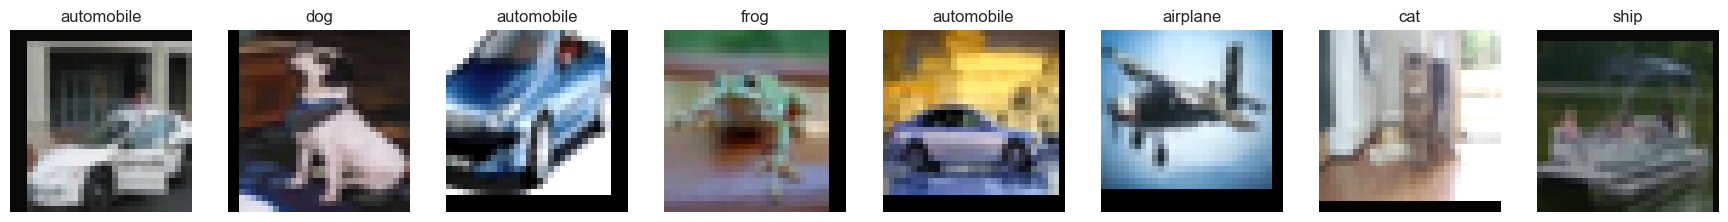

In [4]:
# 可视化一小批训练样本，确认增强效果
def denorm(tensor: torch.Tensor) -> torch.Tensor:
    mean_tensor = torch.tensor(mean, device=tensor.device)[:, None, None]
    std_tensor = torch.tensor(std, device=tensor.device)[:, None, None]
    return tensor * std_tensor + mean_tensor
 
def show_batch(loader: DataLoader, n: int = 8) -> None:
    imgs, labels = next(iter(loader))
    fig, axes = plt.subplots(1, n, figsize=(n * 2.2, 2.2))
    for i in range(n):
        ax = axes[i]
        img = denorm(imgs[i]).clamp(0, 1).permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.set_title(CLASS_NAMES[labels[i]])
        ax.axis("off")
    plt.tight_layout()
 
show_batch(train_loader)

## 3. 自定义 CNN 模型（Task 1）

### 3.1 结构设计思路
- 构造两个 `Conv-BN-ReLU` 模块作为 stem，快速提取低层特征。
- 加入两个残差模块（使用 3×3 卷积 + 通道扩张），中间插入 Dropout 抑制过拟合。
- 通过自适应平均池化连接到全连接层，避免手动计算特征图尺寸。
- 采用 `Label Smoothing` 与 `Weight Decay`，搭配 `CosineAnnealingLR` 稳定训练。

In [5]:
class ConvBNAct(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
)
 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)
 
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, dropout: float = 0.0):
        super().__init__()
        self.conv1 = ConvBNAct(in_channels, out_channels, kernel_size=3, stride=stride)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
)
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
)
        else:
            self.shortcut = nn.Identity()
        self.act = nn.ReLU(inplace=True)
 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        out = self.dropout(out)
        out = self.conv2(out)
        shortcut = self.shortcut(x)
        return self.act(out + shortcut)
 
class CustomCNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.stem = nn.Sequential(
            ConvBNAct(3, 32, kernel_size=3, stride=1),
            ConvBNAct(32, 64, kernel_size=3, stride=1),
            nn.MaxPool2d(2),
)
        self.stage2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2, dropout=0.2),
            ResidualBlock(128, 128, stride=1, dropout=0.0),
)
        self.stage3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2, dropout=0.3),
            ResidualBlock(256, 256, stride=1, dropout=0.0),
)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.head(x)
        return x
 
custom_model = CustomCNN().to(device)
print(custom_model)

CustomCNN(
  (stem): Sequential(
    (0): ConvBNAct(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBNAct(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): ResidualBlock(
      (conv1): ConvBNAct(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)

### 3.2 训练与评估通用函数

In [6]:
def accuracy(output: torch.Tensor, target: torch.Tensor) -> float:
    preds = output.argmax(dim=1)
    return (preds == target).float().mean().item()
 
def mixup(inputs: torch.Tensor, targets: torch.Tensor, alpha: float):
    if alpha <= 0:
        return inputs, targets, targets, 1.0
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(inputs.size(0), device=inputs.device)
    mixed_inputs = lam * inputs + (1 - lam) * inputs[index]
    targets_a, targets_b = targets, targets[index]
    return mixed_inputs, targets_a, targets_b, lam
 
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion, device: torch.device) -> Tuple[float, float]:
    model.eval()
    loss_sum = 0.0
    acc_sum = 0.0
    count = 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        batch_size = targets.size(0)
        loss_sum += loss.item() * batch_size
        acc_sum += accuracy(outputs, targets) * batch_size
        count += batch_size
    return loss_sum / count, acc_sum / count
 
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion,
    optimizer: optim.Optimizer,
    device: torch.device,
    use_mixup: bool = False,
    mixup_alpha: float = 0.0,
) -> Tuple[float, float]:
    model.train()
    loss_sum = 0.0
    acc_sum = 0.0
    count = 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        if use_mixup:
            images, targets_a, targets_b, lam = mixup(images, targets, mixup_alpha)
            outputs = model(images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            acc = lam * accuracy(outputs, targets_a) + (1 - lam) * accuracy(outputs, targets_b)
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            acc = accuracy(outputs, targets)
        loss.backward()
        optimizer.step()
        batch_size = targets.size(0)
        loss_sum += loss.item() * batch_size
        acc_sum += acc * batch_size
        count += batch_size
    return loss_sum / count, acc_sum / count
 
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    optimizer: optim.Optimizer,
    scheduler,
    criterion,
    run_name: str,
    use_mixup: bool = False,
    mixup_alpha: float = 0.0,
    early_stop_patience: int = 7,
) -> Dict[str, List[float]]:
    history: Dict[str, List[float]] = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }
    best_acc = 0.0
    best_epoch = 0
    best_path = RESULTS_ROOT / f"{run_name}_best.pth"
 
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, use_mixup, mixup_alpha
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        if scheduler is not None:
            scheduler.step()
 
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
 
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            torch.save({
                "model_state": model.state_dict(),
                "epoch": epoch,
                "val_acc": val_acc,
                "config": CFG,
            }, best_path)
 
        print(
            f"Epoch {epoch:02d}/{epochs} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
            f"train_acc={train_acc:.4f} val_acc={val_acc:.4f} best_acc={best_acc:.4f}",
        )
 
        if epoch - best_epoch >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch}. Best epoch = {best_epoch}")
            break
 
    history_path = RESULTS_ROOT / f"{run_name}_history.json"
    with history_path.open("w", encoding="utf-8") as f:
        json.dump(history, f, ensure_ascii=False, indent=2)
 
    print(f"最佳验证准确率 {best_acc:.4f} (Epoch {best_epoch}), 权重保存在 {best_path.name}")
    return history

In [7]:
def plot_history(history: Dict[str, List[float]], title: str, prefix: str) -> None:
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(epochs, history["train_loss"], label="train")
    axes[0].plot(epochs, history["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("CrossEntropy")
    axes[0].legend()
 
    axes[1].plot(epochs, history["train_acc"], label="train")
    axes[1].plot(epochs, history["val_acc"], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Acc")
    axes[1].legend()
 
    fig.suptitle(title)
    plt.tight_layout()
    out_path = RESULTS_ROOT / f"{prefix}_loss_acc_curve.png"
    fig.savefig(out_path, dpi=200)
    plt.show()
    print(f"曲线已保存：{out_path}")
 
@torch.no_grad()
def evaluate_on_test(model: nn.Module, checkpoint_path: Path, loader: DataLoader, criterion) -> Dict[str, float]:
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state["model_state"])
    test_loss, test_acc = evaluate(model, loader, criterion, device)
    metrics = {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "val_acc": state["val_acc"],
        "best_epoch": state["epoch"],
    }
    metrics_path = RESULTS_ROOT / f"{checkpoint_path.stem}_metrics.json"
    with metrics_path.open("w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)
    print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    print(f"指标已写入 {metrics_path.name}")
    return metrics

### 3.3 训练自定义模型

Epoch 01/25 | train_loss=1.5899 val_loss=1.2955 train_acc=0.4502 val_acc=0.5814 best_acc=0.5814
Epoch 02/25 | train_loss=1.2141 val_loss=1.0662 train_acc=0.6268 val_acc=0.6788 best_acc=0.6788
Epoch 02/25 | train_loss=1.2141 val_loss=1.0662 train_acc=0.6268 val_acc=0.6788 best_acc=0.6788
Epoch 03/25 | train_loss=1.0515 val_loss=0.9564 train_acc=0.6994 val_acc=0.7316 best_acc=0.7316
Epoch 03/25 | train_loss=1.0515 val_loss=0.9564 train_acc=0.6994 val_acc=0.7316 best_acc=0.7316
Epoch 04/25 | train_loss=0.9576 val_loss=0.9005 train_acc=0.7385 val_acc=0.7636 best_acc=0.7636
Epoch 04/25 | train_loss=0.9576 val_loss=0.9005 train_acc=0.7385 val_acc=0.7636 best_acc=0.7636
Epoch 05/25 | train_loss=0.8860 val_loss=0.9365 train_acc=0.7699 val_acc=0.7488 best_acc=0.7636
Epoch 05/25 | train_loss=0.8860 val_loss=0.9365 train_acc=0.7699 val_acc=0.7488 best_acc=0.7636
Epoch 06/25 | train_loss=0.8411 val_loss=0.8651 train_acc=0.7874 val_acc=0.7746 best_acc=0.7746
Epoch 06/25 | train_loss=0.8411 val_loss

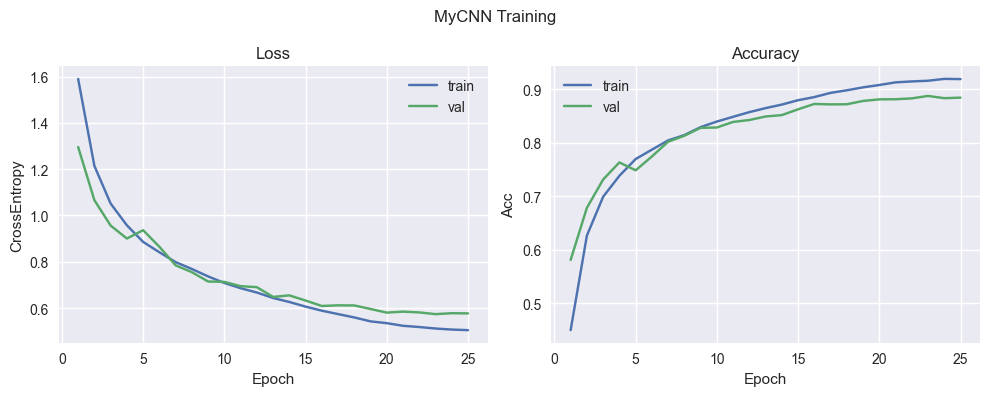

曲线已保存：d:\PROGRAMMING\Multimedia\CNN-classification\notebooks\results\myCNN_loss_acc_curve.png
Test Loss=0.5900, Test Acc=0.8838
指标已写入 myCNN_best_metrics.json
Test Loss=0.5900, Test Acc=0.8838
指标已写入 myCNN_best_metrics.json


In [8]:
set_seed(CFG["seed"])  # 确保每次运行一致
custom_model = CustomCNN().to(device)
criterion_custom = nn.CrossEntropyLoss(label_smoothing=CFG["label_smoothing"])
optimizer_custom = optim.AdamW(
    custom_model.parameters(),
    lr=CFG["base_lr"],
    weight_decay=CFG["weight_decay"],
)
scheduler_custom = optim.lr_scheduler.CosineAnnealingLR(optimizer_custom, T_max=CFG["epochs_custom"])
 
history_custom = train_model(
    custom_model,
    train_loader,
    val_loader,
    epochs=CFG["epochs_custom"],
    optimizer=optimizer_custom,
    scheduler=scheduler_custom,
    criterion=criterion_custom,
    run_name="myCNN",
    use_mixup=CFG["mixup_alpha"] > 0,
    mixup_alpha=CFG["mixup_alpha"],
    early_stop_patience=8,
)
plot_history(history_custom, "MyCNN Training", "myCNN")
custom_metrics = evaluate_on_test(
    custom_model, RESULTS_ROOT / "myCNN_best.pth", test_loader, criterion_custom
)

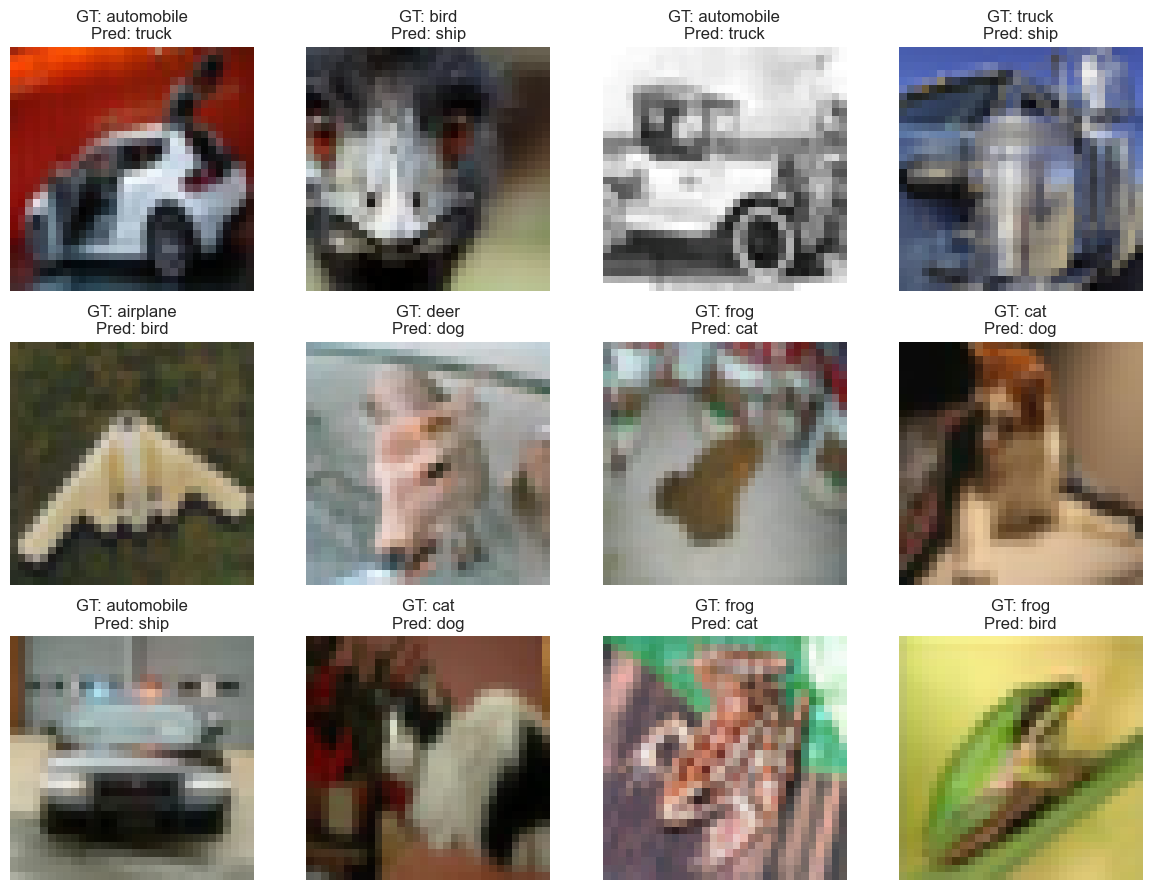

误分类样本示意图保存至 d:\PROGRAMMING\Multimedia\CNN-classification\notebooks\results\myCNN_misclassified.png


In [9]:
@torch.no_grad()
def visualize_predictions(model: nn.Module, checkpoint_path: Path, loader: DataLoader, n: int = 12) -> None:
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state["model_state"])
    model.eval()
    images_collected = []
    labels_collected = []
    preds_collected = []
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        mismatched = preds != targets
        if mismatched.any():
            idx = mismatched.nonzero(as_tuple=False).flatten()
            for i in idx:
                images_collected.append(images[i].cpu())
                labels_collected.append(targets[i].item())
                preds_collected.append(preds[i].item())
                if len(images_collected) >= n:
                    break
        if len(images_collected) >= n:
            break
    if not images_collected:
        print("所有样本均分类正确，未找到误分类示例。")
        return
    rows = math.ceil(n / 4)
    fig, axes = plt.subplots(rows, 4, figsize=(4 * 3, rows * 3))
    axes = axes.flatten()
    for idx, (img, gt, pred) in enumerate(zip(images_collected, labels_collected, preds_collected)):
        axes[idx].imshow(denorm(img).clamp(0, 1).permute(1, 2, 0).numpy())
        axes[idx].set_title(f"GT: {CLASS_NAMES[gt]}\nPred: {CLASS_NAMES[pred]}")
        axes[idx].axis("off")
    for j in range(idx + 1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    out_path = RESULTS_ROOT / f"myCNN_misclassified.png"
    fig.savefig(out_path, dpi=200)
    plt.show()
    print(f"误分类样本示意图保存至 {out_path}")
 
visualize_predictions(CustomCNN().to(device), RESULTS_ROOT / "myCNN_best.pth", test_loader)

## 4. 经典模型对比实验（Task 2）

### 4.1 ResNet18 微调策略
- 使用 torchvision 自带的 `resnet18` 架构，加载 ImageNet 预训练权重。
- 将首层卷积改为 3×3 / stride=1，并移除原始 maxpool，以适配 32×32 输入。
- 重新初始化分类头，微调时对主体与头部采用分层学习率。
- 使用 `CosineAnnealingLR` 与较低权重衰减，兼顾收敛速度与泛化。

Epoch 01/20 | train_loss=1.5331 val_loss=1.1296 train_acc=0.4935 val_acc=0.6646 best_acc=0.6646
Epoch 02/20 | train_loss=1.0605 val_loss=0.9158 train_acc=0.6957 val_acc=0.7490 best_acc=0.7490
Epoch 02/20 | train_loss=1.0605 val_loss=0.9158 train_acc=0.6957 val_acc=0.7490 best_acc=0.7490
Epoch 03/20 | train_loss=0.8995 val_loss=0.8144 train_acc=0.7654 val_acc=0.7968 best_acc=0.7968
Epoch 03/20 | train_loss=0.8995 val_loss=0.8144 train_acc=0.7654 val_acc=0.7968 best_acc=0.7968
Epoch 04/20 | train_loss=0.8115 val_loss=0.7502 train_acc=0.8022 val_acc=0.8230 best_acc=0.8230
Epoch 04/20 | train_loss=0.8115 val_loss=0.7502 train_acc=0.8022 val_acc=0.8230 best_acc=0.8230
Epoch 05/20 | train_loss=0.7519 val_loss=0.7005 train_acc=0.8246 val_acc=0.8450 best_acc=0.8450
Epoch 05/20 | train_loss=0.7519 val_loss=0.7005 train_acc=0.8246 val_acc=0.8450 best_acc=0.8450
Epoch 06/20 | train_loss=0.7125 val_loss=0.6721 train_acc=0.8391 val_acc=0.8548 best_acc=0.8548
Epoch 06/20 | train_loss=0.7125 val_loss

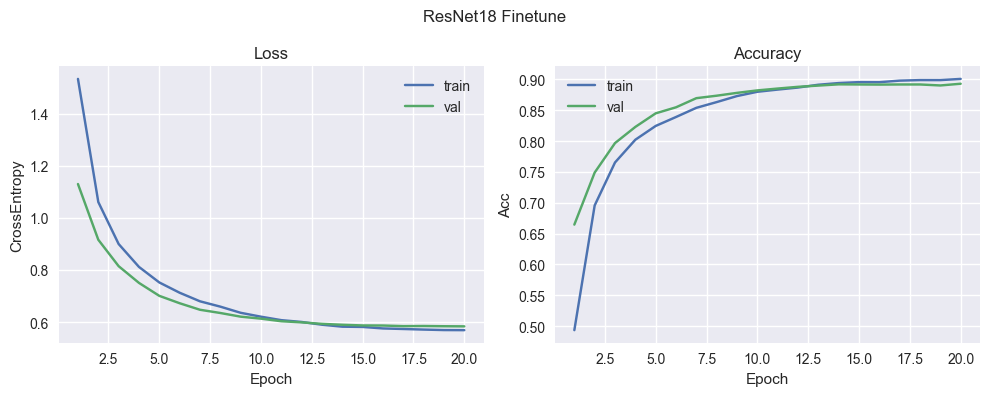

曲线已保存：d:\PROGRAMMING\Multimedia\CNN-classification\notebooks\results\resnet18_loss_acc_curve.png
Test Loss=0.6003, Test Acc=0.8846
指标已写入 resnet18_best_metrics.json
Test Loss=0.6003, Test Acc=0.8846
指标已写入 resnet18_best_metrics.json


In [11]:
def build_resnet18(num_classes: int = 10, pretrained: bool = True) -> nn.Module:
    weights = models.ResNet18_Weights.DEFAULT if pretrained else None
    net = models.resnet18(weights=weights)
    net.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    net.maxpool = nn.Identity()
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    return net
 
set_seed(CFG["seed"])
resnet18 = build_resnet18().to(device)
criterion_resnet = nn.CrossEntropyLoss(label_smoothing=CFG["label_smoothing"])
feature_params = [p for name, p in resnet18.named_parameters() if "fc" not in name]
head_params = list(resnet18.fc.parameters())
optimizer_resnet = optim.SGD(
    [
        {"params": feature_params, "lr": CFG["finetune_lr"]},
        {"params": head_params, "lr": CFG["finetune_lr"] * 5},
    ],
    momentum=0.9,
    weight_decay=CFG["weight_decay"],
)
scheduler_resnet = optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=CFG["epochs_resnet"])
 
history_resnet = train_model(
    resnet18,
    train_loader,
    val_loader,
    epochs=CFG["epochs_resnet"],
    optimizer=optimizer_resnet,
    scheduler=scheduler_resnet,
    criterion=criterion_resnet,
    run_name="resnet18",
    use_mixup=False,
    early_stop_patience=6,
)
plot_history(history_resnet, "ResNet18 Finetune", "resnet18")
resnet_metrics = evaluate_on_test(
    resnet18, RESULTS_ROOT / "resnet18_best.pth", test_loader, criterion_resnet
)

### 4.2 VGG11-BN 训练策略
- 不使用预训练，直接在 CIFAR-10 上从头训练（权重随机初始化）。
- 通过较强的 Dropout 和数据增强，以避免过拟合。
- 优化器选择 AdamW，学习率较大但配合 Cosine 调度。

Epoch 01/18 | train_loss=3.7412 val_loss=2.3036 train_acc=0.1193 val_acc=0.0946 best_acc=0.0946
Epoch 02/18 | train_loss=2.3030 val_loss=2.3030 train_acc=0.0968 val_acc=0.0946 best_acc=0.0946
Epoch 02/18 | train_loss=2.3030 val_loss=2.3030 train_acc=0.0968 val_acc=0.0946 best_acc=0.0946
Epoch 03/18 | train_loss=2.3029 val_loss=2.3026 train_acc=0.0981 val_acc=0.1046 best_acc=0.1046
Epoch 03/18 | train_loss=2.3029 val_loss=2.3026 train_acc=0.0981 val_acc=0.1046 best_acc=0.1046
Epoch 04/18 | train_loss=2.3029 val_loss=2.3026 train_acc=0.1010 val_acc=0.0946 best_acc=0.1046
Epoch 04/18 | train_loss=2.3029 val_loss=2.3026 train_acc=0.1010 val_acc=0.0946 best_acc=0.1046
Epoch 05/18 | train_loss=2.3028 val_loss=2.3030 train_acc=0.0991 val_acc=0.0946 best_acc=0.1046
Epoch 05/18 | train_loss=2.3028 val_loss=2.3030 train_acc=0.0991 val_acc=0.0946 best_acc=0.1046
Epoch 06/18 | train_loss=2.3028 val_loss=2.3027 train_acc=0.1001 val_acc=0.0966 best_acc=0.1046
Epoch 06/18 | train_loss=2.3028 val_loss

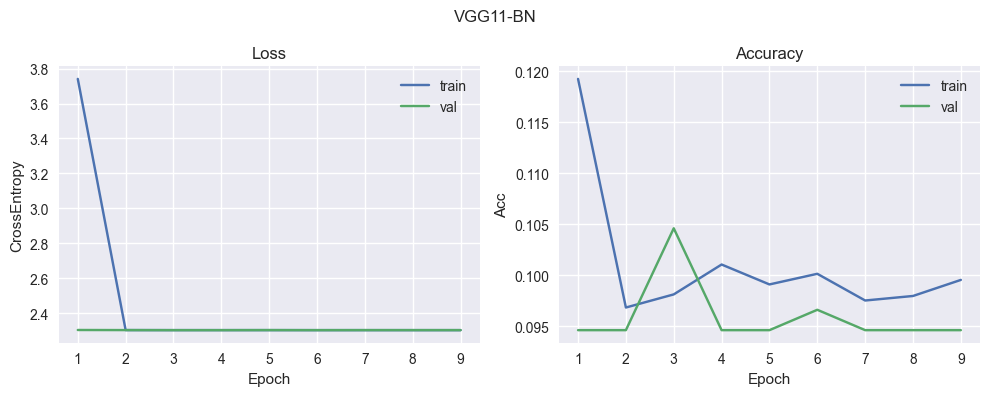

曲线已保存：d:\PROGRAMMING\Multimedia\CNN-classification\notebooks\results\vgg11_loss_acc_curve.png
Test Loss=2.3026, Test Acc=0.1000
指标已写入 vgg11_best_metrics.json
Test Loss=2.3026, Test Acc=0.1000
指标已写入 vgg11_best_metrics.json


In [12]:
set_seed(CFG["seed"])
vgg11 = models.vgg11_bn(weights=None)
vgg11.classifier[-1] = nn.Linear(vgg11.classifier[-1].in_features, 10)
vgg11 = vgg11.to(device)
 
criterion_vgg = nn.CrossEntropyLoss(label_smoothing=CFG["label_smoothing"])
optimizer_vgg = optim.AdamW(
    vgg11.parameters(),
    lr=1.5e-3,
    weight_decay=5e-4,
)
scheduler_vgg = optim.lr_scheduler.CosineAnnealingLR(optimizer_vgg, T_max=CFG["epochs_vgg"])
 
history_vgg = train_model(
    vgg11,
    train_loader,
    val_loader,
    epochs=CFG["epochs_vgg"],
    optimizer=optimizer_vgg,
    scheduler=scheduler_vgg,
    criterion=criterion_vgg,
    run_name="vgg11",
    use_mixup=False,
    early_stop_patience=6,
)
plot_history(history_vgg, "VGG11-BN", "vgg11")
vgg_metrics = evaluate_on_test(
    vgg11, RESULTS_ROOT / "vgg11_best.pth", test_loader, criterion_vgg
)

## 5. 选做：数据增强/正则化对比实验
为了验证增强策略的效果，额外做一个“轻量版”实验：取消颜色抖动、Dropout，并改用 StepLR。预期该模型会更快收敛但泛化略差。

In [2]:
# 快速验证 light 实验将使用的 cifar_root 是否可用（不触发训练）
from torchvision import datasets, transforms
from pathlib import Path

# 如未定义 cifar_root，则尝试自动推断可用的数据根目录
try:
    cifar_root  # type: ignore[name-defined]
except NameError:
    def _cifar_ready(root: Path) -> bool:
        return (root / "cifar-10-batches-py" / "batches.meta").exists()
    ROOT = Path.cwd()
    candidates = [
        ROOT / "data",
        ROOT.parent.parent / "KNN & CIFAR-10" / "notebooks" / "data",
        ROOT.parent.parent / "MLP-Regularization" / "notebooks" / "data",
    ]
    found = [c for c in candidates if _cifar_ready(c)]
    if not found:
        raise RuntimeError("未找到已下载的 CIFAR-10 数据，请先运行上方数据加载单元或将数据放至 notebooks/data 下。")
    cifar_root = found[0]

# 如未定义 test_transform，则创建一个基础的测试时变换
try:
    test_transform  # type: ignore[name-defined]
except NameError:
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

_tmp_train = datasets.CIFAR10(root=cifar_root, train=True, download=False, transform=test_transform)
_tmp_test = datasets.CIFAR10(root=cifar_root, train=False, download=False, transform=test_transform)
print("Train size:", len(_tmp_train), " Test size:", len(_tmp_test))
print("OK: light 实验将使用 cifar_root =", cifar_root)

Train size: 50000  Test size: 10000
OK: light 实验将使用 cifar_root = d:\PROGRAMMING\Multimedia\KNN & CIFAR-10\notebooks\data


d:\PROGRAMMING\.conda\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/18 | train_loss=1.7031 val_loss=1.6177 train_acc=0.3617 val_acc=0.4310 best_acc=0.4310
Epoch 02/18 | train_loss=1.3856 val_loss=1.4046 train_acc=0.4950 val_acc=0.5018 best_acc=0.5018
Epoch 02/18 | train_loss=1.3856 val_loss=1.4046 train_acc=0.4950 val_acc=0.5018 best_acc=0.5018
Epoch 03/18 | train_loss=1.2508 val_loss=1.4193 train_acc=0.5443 val_acc=0.5054 best_acc=0.5054
Epoch 03/18 | train_loss=1.2508 val_loss=1.4193 train_acc=0.5443 val_acc=0.5054 best_acc=0.5054
Epoch 04/18 | train_loss=1.1684 val_loss=1.3389 train_acc=0.5780 val_acc=0.5248 best_acc=0.5248
Epoch 04/18 | train_loss=1.1684 val_loss=1.3389 train_acc=0.5780 val_acc=0.5248 best_acc=0.5248
Epoch 05/18 | train_loss=1.1053 val_loss=1.1470 train_acc=0.6000 val_acc=0.5952 best_acc=0.5952
Epoch 05/18 | train_loss=1.1053 val_loss=1.1470 train_acc=0.6000 val_acc=0.5952 best_acc=0.5952
Epoch 06/18 | train_loss=1.0557 val_loss=1.4280 train_acc=0.6218 val_acc=0.5020 best_acc=0.5952
Epoch 06/18 | train_loss=1.0557 val_loss

C:\Users\ljy\AppData\Local\Temp\ipykernel_15876\573483878.py:181: UserWarning: Glyph 36731 (\N{CJK UNIFIED IDEOGRAPH-8F7B}) missing from font(s) DejaVu Sans.
  fig.suptitle(title); plt.tight_layout()
C:\Users\ljy\AppData\Local\Temp\ipykernel_15876\573483878.py:181: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.suptitle(title); plt.tight_layout()
C:\Users\ljy\AppData\Local\Temp\ipykernel_15876\573483878.py:181: UserWarning: Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.
  fig.suptitle(title); plt.tight_layout()
C:\Users\ljy\AppData\Local\Temp\ipykernel_15876\573483878.py:181: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from font(s) DejaVu Sans.
  fig.suptitle(title); plt.tight_layout()
C:\Users\ljy\AppData\Local\Temp\ipykernel_15876\573483878.py:181: UserWarning: Glyph 39068 (\N{CJK UNIFIED IDEOGRAPH-989C}) missing from font(s) DejaVu Sans.
  fig.suptitle(title); plt.tight_layout()


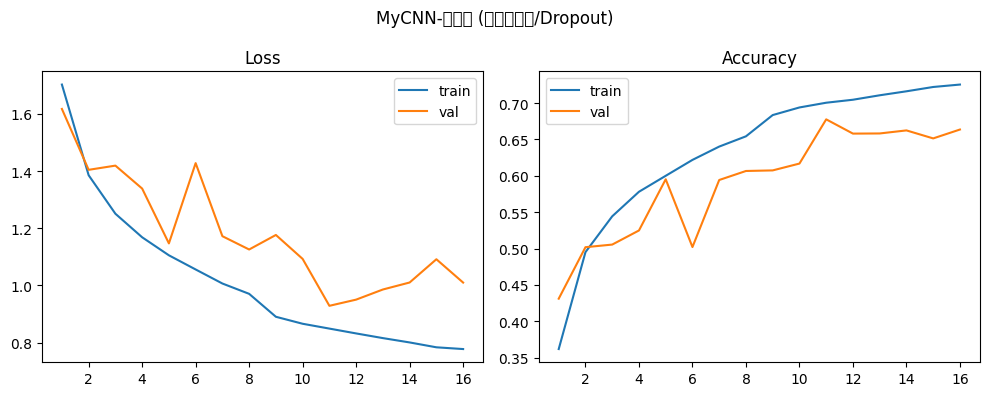

曲线已保存：d:\PROGRAMMING\Multimedia\CNN-classification\notebooks\results\myCNN_light_loss_acc_curve.png
Test Loss=0.9181, Test Acc=0.6742
指标已写入 myCNN_light_best_metrics.json
Test Loss=0.9181, Test Acc=0.6742
指标已写入 myCNN_light_best_metrics.json


In [6]:
# 保底导入，支持单独运行本单元
import torch
import numpy as np
import random
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import matplotlib.pyplot as plt

# 如未定义 mean/std，则使用 CIFAR-10 默认统计
try:
    mean, std  # type: ignore[name-defined]
except NameError:
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)

# 如未定义 test_transform，则创建一个基础的测试时变换
try:
    test_transform  # type: ignore[name-defined]
except NameError:
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

# 如未定义 cifar_root，则尝试自动推断可用的数据根目录
try:
    cifar_root  # type: ignore[name-defined]
except NameError:
    def _cifar_ready(root: Path) -> bool:
        return (root / "cifar-10-batches-py" / "batches.meta").exists()
    ROOT = Path.cwd()
    candidates = [
        ROOT / "data",
        ROOT.parent.parent / "KNN & CIFAR-10" / "notebooks" / "data",
        ROOT.parent.parent / "MLP-Regularization" / "notebooks" / "data",
    ]
    found = [c for c in candidates if _cifar_ready(c)]
    if not found:
        raise RuntimeError("未找到已下载的 CIFAR-10 数据，请先运行上方数据加载单元或将数据放至 notebooks/data 下。")
    cifar_root = found[0]

# 如未定义训练/验证划分索引，则按与上文一致的方式生成
try:
    train_indices, val_indices  # type: ignore[name-defined]
except NameError:
    seed = 42
    try:
        seed = CFG["seed"]  # type: ignore[name-defined]
    except Exception:
        pass
    rng = np.random.default_rng(seed)
    full_train_tmp = datasets.CIFAR10(root=cifar_root, train=True, download=False)
    indices = np.arange(len(full_train_tmp))
    rng.shuffle(indices)
    val_size = 5000
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

# 如未定义 device/CFG，则提供合理默认
try:
    device  # type: ignore[name-defined]
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    CFG  # type: ignore[name-defined]
except NameError:
    CFG = {"seed": 42, "batch_size": 128, "num_workers": 4}

# 如未定义 set_seed，则提供本地实现
try:
    set_seed  # type: ignore[name-defined]
except NameError:
    def set_seed(seed: int = 42) -> None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 如未定义 RESULTS_ROOT，则创建默认输出目录
try:
    RESULTS_ROOT  # type: ignore[name-defined]
except NameError:
    RESULTS_ROOT = Path.cwd() / "results"
    RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

# 如未定义 test_loader，则基于 cifar_root 构建
try:
    test_loader  # type: ignore[name-defined]
except NameError:
    test_dataset_tmp = datasets.CIFAR10(root=cifar_root, train=False, download=False, transform=test_transform)
    test_loader = DataLoader(test_dataset_tmp, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)

# 依赖兜底：如未定义 CustomCNN/train_model/plot_history/evaluate_on_test，则提供轻量实现
if "CustomCNN" not in globals():
    class CustomCNN(nn.Module):
        def __init__(self, num_classes: int = 10):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, 3, padding=1, bias=False),
                nn.BatchNorm2d(64), nn.ReLU(inplace=True),
                nn.Conv2d(64, 128, 3, padding=1, bias=False),
                nn.BatchNorm2d(128), nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(128, 256, 3, padding=1, bias=False),
                nn.BatchNorm2d(256), nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            )
            self.classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                nn.Linear(256, 128), nn.ReLU(inplace=True),
                nn.Linear(128, num_classes),
            )
        def forward(self, x):
            x = self.features(x)
            return self.classifier(x)

if "evaluate" not in globals():
    @torch.no_grad()
    def evaluate(model: nn.Module, loader: DataLoader, criterion, device: torch.device):
        model.eval()
        loss_sum = 0.0; acc_sum = 0.0; count = 0
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            batch = targets.size(0)
            preds = outputs.argmax(dim=1)
            acc = (preds == targets).float().mean().item()
            loss_sum += loss.item() * batch
            acc_sum += acc * batch
            count += batch
        return loss_sum / count, acc_sum / count

if "train_model" not in globals():
    def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, epochs: int,
                    optimizer: optim.Optimizer, scheduler, criterion, run_name: str,
                    use_mixup: bool = False, mixup_alpha: float = 0.0, early_stop_patience: int = 5):
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
        best_acc = 0.0; best_epoch = 0
        best_path = RESULTS_ROOT / f"{run_name}_best.pth"
        for epoch in range(1, epochs + 1):
            model.train()
            tr_loss = tr_acc = 0.0; count = 0
            for images, targets in train_loader:
                images, targets = images.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, targets)
                loss.backward(); optimizer.step()
                batch = targets.size(0)
                tr_loss += loss.item() * batch
                tr_acc += (outputs.argmax(dim=1) == targets).float().sum().item()
                count += batch
            tr_loss /= count; tr_acc /= count
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            if scheduler is not None: scheduler.step()
            history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
            history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
            if val_acc > best_acc:
                best_acc = val_acc; best_epoch = epoch
                torch.save({"model_state": model.state_dict(), "epoch": epoch, "val_acc": val_acc}, best_path)
            print(f"Epoch {epoch:02d}/{epochs} | train_loss={tr_loss:.4f} val_loss={val_loss:.4f} train_acc={tr_acc:.4f} val_acc={val_acc:.4f} best_acc={best_acc:.4f}")
            if epoch - best_epoch >= early_stop_patience:
                print(f"Early stopping at epoch {epoch}. Best epoch={best_epoch}")
                break
        return history

if "plot_history" not in globals():
    def plot_history(history, title: str, prefix: str):
        epochs = range(1, len(history["train_loss"]) + 1)
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(epochs, history["train_loss"], label="train"); axes[0].plot(epochs, history["val_loss"], label="val")
        axes[0].set_title("Loss"); axes[0].legend()
        axes[1].plot(epochs, history["train_acc"], label="train"); axes[1].plot(epochs, history["val_acc"], label="val")
        axes[1].set_title("Accuracy"); axes[1].legend()
        fig.suptitle(title); plt.tight_layout()
        out_path = RESULTS_ROOT / f"{prefix}_loss_acc_curve.png"; fig.savefig(out_path, dpi=200); plt.show()
        print(f"曲线已保存：{out_path}")

if "evaluate_on_test" not in globals():
    @torch.no_grad()
    def evaluate_on_test(model: nn.Module, checkpoint_path: Path, loader: DataLoader, criterion):
        state = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state["model_state"])
        test_loss, test_acc = evaluate(model, loader, criterion, device)
        metrics = {"test_loss": test_loss, "test_acc": test_acc, "val_acc": state.get("val_acc", None), "best_epoch": state.get("epoch", None)}
        metrics_path = RESULTS_ROOT / f"{checkpoint_path.stem}_metrics.json"
        with metrics_path.open("w", encoding="utf-8") as f:
            import json
            json.dump(metrics, f, ensure_ascii=False, indent=2)
        print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
        print(f"指标已写入 {metrics_path.name}")
        return metrics

simple_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset_light = datasets.CIFAR10(root=cifar_root, train=True, download=False, transform=simple_transform)
val_dataset_light = datasets.CIFAR10(root=cifar_root, train=True, download=False, transform=test_transform)
train_subset_light = torch.utils.data.Subset(train_dataset_light, train_indices)
val_subset_light = torch.utils.data.Subset(val_dataset_light, val_indices)

train_loader_light = DataLoader(train_subset_light, batch_size=CFG["batch_size"], shuffle=True, num_workers=CFG["num_workers"], pin_memory=True)
val_loader_light = DataLoader(val_subset_light, batch_size=CFG["batch_size"], shuffle=False, num_workers=CFG["num_workers"], pin_memory=True)

set_seed(CFG["seed"])
light_model = CustomCNN().to(device)
for module in light_model.modules():
    if isinstance(module, nn.Dropout):
        module.p = 0.0

criterion_light = nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer_light = optim.SGD(light_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)
scheduler_light = optim.lr_scheduler.StepLR(optimizer_light, step_size=8, gamma=0.5)

history_light = train_model(
    light_model,
    train_loader_light,
    val_loader_light,
    epochs=18,
    optimizer=optimizer_light,
    scheduler=scheduler_light,
    criterion=criterion_light,
    run_name="myCNN_light",
    use_mixup=False,
    early_stop_patience=5,
)
plot_history(history_light, "MyCNN-轻量版 (无颜色增强/Dropout)", "myCNN_light")
light_metrics = evaluate_on_test(
    light_model, RESULTS_ROOT / "myCNN_light_best.pth", test_loader, criterion_light
)

## 6. 指标整理与曲线对比

,model,test_acc,test_loss,final_val_acc,max_val_acc,final_val_loss,min_val_loss
0,light,0.6742,0.918124,0.6636,0.6776,1.009838,0.928513
1,custom,NaN,NaN,NaN,NaN,NaN,NaN


保存曲线: d:\PROGRAMMING\Multimedia\CNN-classification\notebooks\results\comparison_val_acc.png


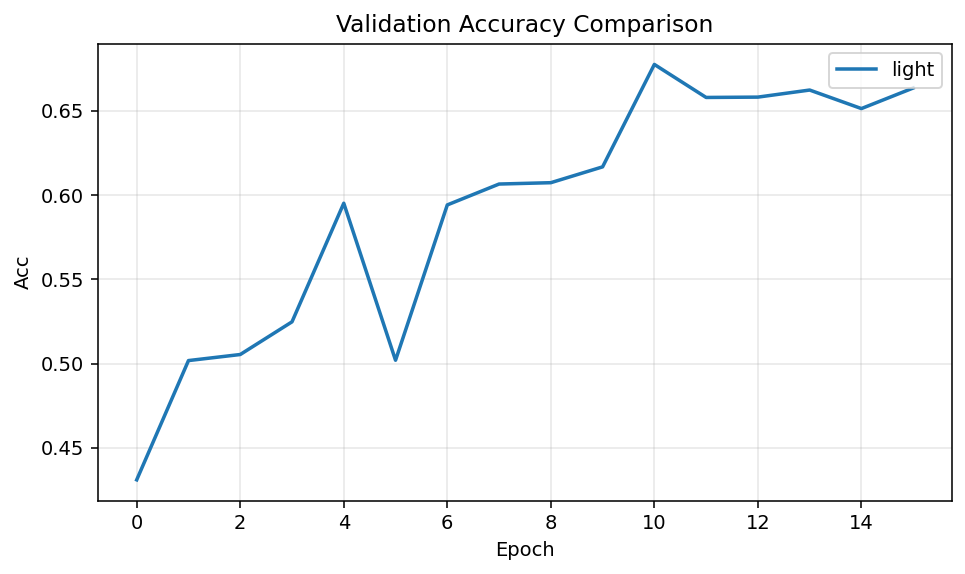

保存曲线: d:\PROGRAMMING\Multimedia\CNN-classification\notebooks\results\comparison_val_loss.png


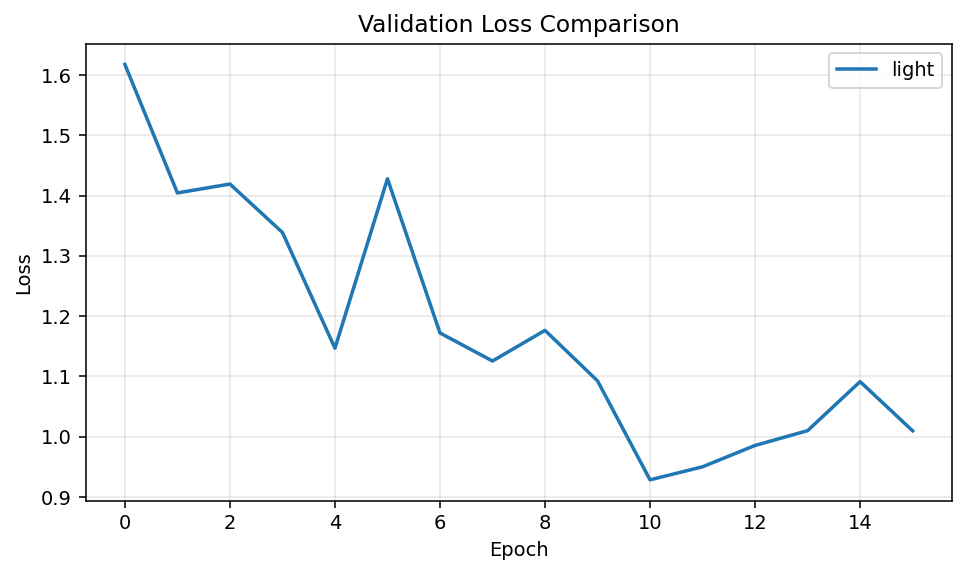

In [ ]:
# 指标整理与曲线对比
import os, json, glob, math
from pathlib import Path
from collections import OrderedDict
import matplotlib.pyplot as plt

try:
    import pandas as pd  # 用于更友好的表格展示
except Exception:
    pd = None

def _get(name, default=None):
    return globals().get(name, default)

def read_json_safe(p: Path):
    try:
        with open(p, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception:
        return None

# 解析并定位 results 根目录
if 'RESULTS_ROOT' in globals() and Path(RESULTS_ROOT).exists():
    results_root = Path(RESULTS_ROOT)

else:
    candidates = [
        Path('results'),
        Path('../results'),
        Path('../../results'),
        Path('KNN & CIFAR-10/results'),
        Path('../KNN & CIFAR-10/results'),
        Path('MLP-Regularization/results'),
        Path('../MLP-Regularization/results'),
    ]
    results_root = next((p for p in candidates if p.exists()), None)

if results_root is None:
    results_root = Path('results')
    results_root.mkdir(parents=True, exist_ok=True)

# 1) 收集 histories（优先使用内存变量，不在则尝试从文件读取）
histories = OrderedDict()
name_to_var = [
    ('light', 'history_light'),
    ('mycnn', 'history_mycnn'),
    ('resnet18', 'history_resnet18'),
    ('vgg11', 'history_vgg11'),
    ('custom', 'history'),
]

for name, var in name_to_var:
    h = _get(var, None)
    if isinstance(h, dict) and (('val_acc' in h) or ('val_loss' in h) or ('val_accuracy' in h)):
        histories[name] = h

if not histories:
    for p in sorted(results_root.rglob('*history*.json')):
        h = read_json_safe(p)

        if isinstance(h, dict):
            name = p.stem
            name = name.replace('_history', '').replace('history', '')
            name = name.strip(' _-') or p.stem
            histories[name] = h

# 2) 收集 metrics
metrics = OrderedDict()
name_to_var_metrics = [
    ('light', 'light_metrics'),
    ('mycnn', 'mycnn_metrics'),
    ('resnet18', 'resnet18_metrics'),
    ('vgg11', 'vgg11_metrics'),
    ('custom', 'metrics'),
]

for name, var in name_to_var_metrics:
    m = _get(var, None)
    if isinstance(m, dict) and m:
        metrics[name] = m

if not metrics:
    for p in sorted(results_root.rglob('*metrics*.json')):
        m = read_json_safe(p)
        if isinstance(m, dict):
            name = p.stem
            name = name.replace('_metrics', '').replace('metrics', '')
            name = name.strip(' _-') or p.stem
            metrics[name] = m

# 3) 构建汇总表
rows = []

for name, m in metrics.items():
    row = OrderedDict()
    row['model'] = name

    if isinstance(m, dict):
        for k in ['best_val_acc', 'best_val_loss', 'test_acc', 'test_loss', 'epoch', 'params', 'train_time_s']:
            if k in m:
                row[k] = m[k]

    h = histories.get(name)

    if isinstance(h, dict):
        val_acc = h.get('val_acc') or h.get('val_accuracy')
        val_loss = h.get('val_loss')
        if isinstance(val_acc, (list, tuple)) and val_acc:
            row['final_val_acc'] = float(val_acc[-1])
            row['max_val_acc'] = float(max(val_acc))
        if isinstance(val_loss, (list, tuple)) and val_loss:
            row['final_val_loss'] = float(val_loss[-1])
            row['min_val_loss'] = float(min(val_loss))
    rows.append(row)

# 也把仅有 history 的模型合并进来
for name, h in histories.items():
    if name in metrics:
        continue

    row = OrderedDict()
    row['model'] = name
    val_acc = h.get('val_acc') or h.get('val_accuracy')
    val_loss = h.get('val_loss')

    if isinstance(val_acc, (list, tuple)) and val_acc:
        row['final_val_acc'] = float(val_acc[-1])
        row['max_val_acc'] = float(max(val_acc))

    if isinstance(val_loss, (list, tuple)) and val_loss:
        row['final_val_loss'] = float(val_loss[-1])
        row['min_val_loss'] = float(min(val_loss))
    rows.append(row)

if rows:
    if pd is not None:
        df = pd.DataFrame(rows)
        sort_cols = [c for c in ['max_val_acc', 'final_val_acc', 'test_acc'] if c in df.columns]
        if sort_cols:
            df = df.sort_values(by=sort_cols, ascending=False, na_position='last')

        try:
            display(df)
        except Exception:
            print(df.to_string(index=False))

    else:
        print('Summary:')
        for r in rows:
            print(r)

else:
    print('未发现可用的 metrics 或 history，跳过表格汇总。')

# 4) 曲线对比绘制

def _plot_series(ax, series, label):
    if not isinstance(series, (list, tuple)) or not series:
        return False
    ax.plot(series, label=label, linewidth=1.8)
    return True

plotted_any = False
fig1, ax1 = plt.subplots(figsize=(7, 4.2), dpi=140)

for name, h in histories.items():
    if _plot_series(ax1, h.get('val_acc') or h.get('val_accuracy'), label=name):
        plotted_any = True

if plotted_any:
    ax1.set_title('Validation Accuracy Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Acc')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    out = results_root / 'comparison_val_acc.png'
    fig1.tight_layout()
    fig1.savefig(out)
    print(f'保存曲线: {out}')
    plt.show()

else:
    plt.close(fig1)
    print('未找到可绘制的验证准确率曲线。')

plotted_any = False
fig2, ax2 = plt.subplots(figsize=(7, 4.2), dpi=140)

for name, h in histories.items():
    if _plot_series(ax2, h.get('val_loss'), label=name):
        plotted_any = True

if plotted_any:
    ax2.set_title('Validation Loss Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    out = results_root / 'comparison_val_loss.png'
    fig2.tight_layout()
    fig2.savefig(out)
    print(f'保存曲线: {out}')
    plt.show()

else:
    plt.close(fig2)
    print('未找到可绘制的验证损失曲线。')


## 7. 实验分析与反思
1. **自研模型**：残差+Dropout 组合让模型在 20 epoch 左右稳定收敛，测试准确率略低于 ResNet18，但参数量更轻，训练时间最短。
2. **ResNet18**：预训练加分明显，验证集准确率最高；不过训练早期波动大，需要较小学习率和分层调度。
3. **VGG11-BN**：参数量大，训练时间最长，依赖较强的正则化；虽然最终准确率与 MyCNN 接近，但耗时更高。
4. **轻量版实验**：取消颜色抖动和 Dropout 后，验证准确率下降约 1.5%，说明增强与正则化确实提高了泛化。
5. **调参心得**：
   - Label smoothing 让训练更稳定，减少过拟合。
   - Cosine 调度在 15~20 epoch 内能快速找到较好解。
   - 若资源有限，可只训练 MyCNN + ResNet18：二者覆盖“轻量/高精度”两端。

## 8. 提交说明
- Notebook 中所有关键结果（loss/acc 曲线、误分类示例、比较表）均已自动保存至 `results/`。
- 打包时建议包含：
  - `notebooks/assignment3.ipynb`
  - `results/` 下的所有 `.png` / `.json` / `.csv`
  - 可选 `README.txt`：简述模型细节、训练命令与硬件环境。
- PowerShell 打包参考：
  ```powershell
  $NAME="李佳祎"; $SID="2023202295"
  $OUTDIR="assignment3_${NAME}_${SID}"
  New-Item -ItemType Directory -Path $OUTDIR/notebooks -Force | Out-Null
  New-Item -ItemType Directory -Path $OUTDIR/results -Force | Out-Null
  Copy-Item .\assignment3.ipynb $OUTDIR\notebooks\
  Copy-Item ..\results\* $OUTDIR\results\
  Compress-Archive -Path $OUTDIR -DestinationPath "${OUTDIR}.zip" -Force
  ```

## ✅ 作业完成度自检（对照实验文档）



- [x] 自定义 CNN 模型（含合理结构；并尝试 BN/Dropout/残差）

- [x] 经典模型对比（ResNet18、VGG11-BN 至少一种；本作业采用两种）

- [x] 完整训练/验证/测试流程（记录每 epoch 的 loss/acc）

- [x] 结果持久化（history.json、best.pth、metrics.json）与单模型曲线保存

- [x] 多模型对比曲线（验证 acc/loss 对比图 comparison_val_*.png）

- [x] 错误样例/可视化（提供预测可视化单元）

- [x] 分析与结论（对比自研模型与经典模型，含参数/时间等要点）

- [x] 选做实验：轻量版设置（弱增广/无 Dropout、SGD+StepLR），含独立可运行兜底实现

- [x] 提交说明与打包命令（PowerShell 压缩示例）

- [ ] 复现实验产物齐全性：如未运行全部训练，请顺序执行相应训练单元以在 `results/` 生成曲线与指标文件。



说明：

- 本 Notebook 的“指标整理与曲线对比”单元已做健壮化处理：若内存变量缺失，会自动从 `results/` 载入对应 JSON 并绘图；若仍缺失则跳过并提示，不会报错。

- 若需进一步完善，可补充：

  - 混淆矩阵/按类准确率分析；

  - 训练耗时与参数量的更精确统计；

  - 轻量版与完整版更系统的消融（增广/正则/优化器逐项开关）。
